# Estimate velocity uncertainty in the upper 20 m of the ocean

Steps:
    - Load the estimated density parameters
    - Calculate the density difference between 0 and 20 m (as a side plot)
    - Calculate the mode shapes (1 & 2)
    - Calculate the velocities at near surface and 20 m for different amplitude waves (20 and 40 m)
    
##Velocity calculation

Linear theory:
$$
u = a c\frac{d \phi}{dz} 
$$ 

Weakly nonlinear theory
$$
u = a c \left(\frac{d \phi}{dz} + a c \frac{d \phi^{1,0}}{dz} \right)
$$ 

where

$$
\phi(z) = f\left(\rho(z)\right) = f\left(T(z)\right)
$$

i.e. $\phi(z)$, and hence the velocity profile, is a function of the *vertical* density (temperature) stratification.

Note that $\phi(z)$ has many solutions for each density profile --> we call these different solutions, **modes** and write

$$
u_n = a c_n\frac{d \phi_n}{dz} 
$$ 

where subscript $n$ indicates the mode number.

See Manderson, et al for details of how the density profile uncertainty was quantified (https://journals.ametsoc.org/view/journals/atot/36/7/jtech-d-18-0200.1.xml)

In [1]:
import h5py
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

from iwaves import kdv
from iwaves.utils import isw
from tqdm import tqdm # progress bar
from glob import glob
import os

import pdb

In [16]:
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['font.size'] = 14

In [3]:
# def load_density_h5(h5file):
#     f = h5py.File(h5file,'r')
#     #rho = f['data/rho'][:]
#     #depth = f['data/z'][:]
#     data = f['beta_samples'][:]
#     time = f['data/time'][:].astype('<M8[ns]')
#     rho_std = f['data/rho_std'].value
#     rho_mu = f['data/rho_mu'].value
#     z_std = f['data/z_std'].value
#     f.close()
#     #return data,time, rho, depth, rho_std, z_std, rho_mu
#     return data,time, rho_std, z_std, rho_mu

def load_beta_h5(betafile):
    # Get the time from the beta file
    with h5py.File(betafile,'r') as f:
        t_beta=f['data/time'][:].astype('<M8[ns]')
        beta_samples = f['beta_samples'][:]
        z_std = np.array(f['data/z_std'])
        rho_std = np.array(f['data/rho_std'])
        rho_mu = np.array(f['data/rho_mu'])

    nparams, nt, nsamples = beta_samples.shape

    # Scale the beta parameters
    beta_samples[0,...] *= rho_std
    beta_samples[0,...] += rho_mu
    beta_samples[1,...] *= rho_std
    beta_samples[2::,...] *= z_std
    
    return beta_samples, t_beta


def single_tanh(beta, z):
    
    return beta[0] - beta[1]*np.tanh((z+beta[2])/beta[3])

def double_tanh(beta, z):
    
    return beta[0] - beta[1]*(np.tanh((z+beta[2])/beta[3])
            + np.tanh((z+beta[4])/beta[5]))

def double_tanh_6(beta, z):
    
    return beta[0] - beta[1]*(np.tanh((z+beta[2])/beta[3])
            + np.tanh((z+beta[2] + beta[4])/beta[5]))

def double_tanh_7(beta, z):
    return beta[0] - beta[1]*np.tanh((z+beta[2])/beta[3]) \
        - beta[6]* np.tanh((z+beta[2] + beta[4])/beta[5])


In [4]:
def calc_nliw_params(h5file, zmin, dz, \
            zsurf=-20, amps=[20.,40.], modes=[0,1], samples=None):
    
    # Lload the data
    #data,time, rho, depth, rho_std, z_std, rho_mu = load_density_h5(h5file)
    #data,time, rho_std, z_std, rho_mu = load_density_h5(h5file)
    z_std = 1.
    rho_std = 1.
    rho_mu = 0.
    data,time = load_beta_h5(h5file)
    nparams, nt, ntrace = data[:].shape
    
    zout = np.arange(0,zmin, -dz)
    
    zidx = np.argwhere(z<=zsurf)[0,0]
    print(zsurf, zidx)

    # Calculate c and alpha
    if samples is None:
        samples = ntrace
    
    
    # Length of other dimensions
    nmodes = len(modes)
    namps = len(amps)
    nz = zout.shape[0]
        
    drho_ens = np.zeros((nt, samples))
    usurf_ens = np.zeros((nt, nmodes, namps, samples))

    du_ens = np.zeros((nt, nmodes, namps, samples))
    alpha_ens = np.zeros((nt,nmodes,samples))
    c_ens = np.zeros((nt,nmodes, samples))
    beta_ens = np.zeros((nt, samples, nparams))

    rand_loc = np.random.randint(0, ntrace, samples)

    for tstep in  tqdm(range(0,nt)):
        #if (tstep%20==0):
        #    print('%d of %d...'%(tstep,nt))
        for ii in range(samples):
            beta_ii = data[:,tstep, rand_loc[ii]]
            beta_ens[tstep,ii,:] = beta_ii
            
            if nparams == 4:
                rhotmp = single_tanh(data[:,tstep, rand_loc[ii]], zout/z_std)
            elif nparams == 6:
                rhotmp = double_tanh(beta_ii, zout/z_std)
            elif nparams == 7:
                rhotmp = double_tanh_7(data[:,tstep, rand_loc[ii]], zout/z_std)

            # Need to scale rho
            rhotmp = rhotmp*rho_std + rho_mu
            
            drho_ens[tstep,ii] = rhotmp[0] - rhotmp[zidx]


            N2 = -9.81/1000*np.gradient(rhotmp,-dz)

            phi,cn = isw.iwave_modes(N2, dz)
            
            for mm, mode in enumerate(modes):

                phi_1 = phi[:,mode]
                phi_1 =phi_1 / np.abs(phi_1).max()
                phi_1 *= np.sign(phi_1.sum())
                
                phi10 = isw.calc_phi10(phi_1, cn[mode], N2, dz)

                alpha = isw.calc_alpha(phi_1, cn[mode],N2,dz)

                alpha_ens[tstep, mm, ii] = alpha
                c_ens[tstep, mm, ii] = cn[mode]
                
                for aa, amp in enumerate(amps):
                    phi_z = np.gradient(phi_1,-dz)
                    phi10_z = np.gradient(phi10,-dz)

                    u = amp*cn[mode]*phi_z
                    u += amp**2*cn[mode]**2*phi10_z # Nonlinear adjustment
                    
                    du_ens[tstep,mm,aa,ii] = u[0] - u[zidx]
                    usurf_ens[tstep,mm,aa,ii] = u[0]
                    
            #mykdv = kdv.KdV(rhotmp,zout)
            
    # Export to an xarray data set
    # Create an xray dataset with the output
    dims2 = ('time','ensemble',)
    dimsc = ('time','mode','ensemble',)
    dimsu = ('time','mode','amp','ensemble',)

    #dims2a = ('time','depth',)
    dims3 = ('time','ensemble','params')

    #time = rho.time.values
    #time = range(nt)
    coords2 = {'time':time, 'ensemble':range(samples)}
    coordsc = {'time':time, 'mode':modes,'ensemble':range(samples)}
    coordsu = {'time':time, 'mode':modes,'amp':amps,'ensemble':range(samples)}

    #coords2a = {'time':time, 'depth':depth[:,0]}
    coords3 = {'time':time, 'ensemble':range(samples), 'params':range(nparams)}


    #rho = xr.DataArray(rho.T,
    #    coords=coords2a,
    #    dims=dims2a,
    #    attrs={'long_name':'', 'units':''},
    #    )
     
    cn_da = xr.DataArray(c_ens,
        coords=coordsc,
        dims=dimsc,
        attrs={'long_name':'', 'units':''},
        )

    alpha_da = xr.DataArray(alpha_ens,
        coords=coordsc,
        dims=dimsc,
        attrs={'long_name':'', 'units':''},
        )
    
    
    du_da = xr.DataArray(du_ens,
        coords=coordsu,
        dims=dimsu,
        attrs={'long_name':'', 'units':''},
        )
    
    usurf_da = xr.DataArray(usurf_ens,
        coords=coordsu,
        dims=dimsu,
        attrs={'long_name':'', 'units':''},
        )
    
    drho_da = xr.DataArray(drho_ens,
        coords=coords2,
        dims=dims2,
        attrs={'long_name':'', 'units':''},
        )
    beta_da = xr.DataArray(beta_ens,
        coords=coords3,
        dims=dims3,
        attrs={'long_name':'', 'units':''},
        )

    dsout = xr.Dataset({'cn':cn_da, 'alpha':alpha_da, 'beta':beta_da,
                       'du':du_da, 'usurf':usurf_da, 'drho':drho_da})
    
    return dsout


In [10]:
# Load pre-computed values
datadir = '../inputs/'
h5file = '%s/ShellCrux_Filtered_Density_Harmonic_MCMC_20162017_prediction.h5'%datadir
outfile =  '%s_velocity.nc'%h5file[:-3]

dsout = xr.open_dataset(outfile)
dsout

<xarray.Dataset>
Dimensions:   (amp: 2, ensemble: 500, mode: 2, params: 6, time: 369)
Coordinates:
  * time      (time) datetime64[ns] 2016-05-03T05:15:00 ... 2017-05-07T18:40:00
  * mode      (mode) int64 0 1
  * ensemble  (ensemble) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * params    (params) int64 0 1 2 3 4 5
  * amp       (amp) float64 20.0 40.0
Data variables:
    cn        (time, mode, ensemble) float64 ...
    alpha     (time, mode, ensemble) float64 ...
    beta      (time, ensemble, params) float64 ...
    du        (time, mode, amp, ensemble) float64 ...
    usurf     (time, mode, amp, ensemble) float64 ...
    drho      (time, ensemble) float64 ...

In [11]:
def plot_ensemble(time, A, axis=0, c='b'):
    mu = A.mean(axis=axis)
    c5 = np.percentile(A, 2.5, axis=axis)
    c95 = np.percentile(A, 97.5, axis=axis)
    
    plt.plot(time, mu, c)
    plt.fill_between(time, c5, c95, color=c, alpha=0.5)
    plt.xlim(time[0],time[-1])
    plt.grid(b=True, ls=':')

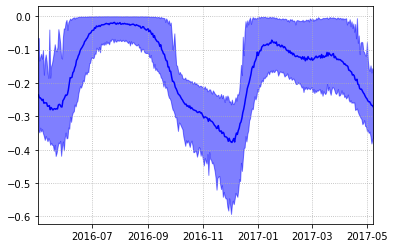

In [12]:
plt.figure()
plot_ensemble(dsout['time'], dsout['drho'], axis=1)

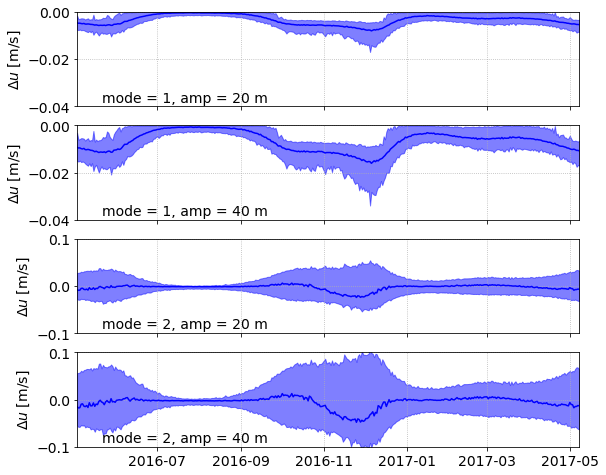

In [26]:

plt.figure(figsize=(9,8))
ax=plt.subplot(411)
plot_ensemble(dsout['time'], dsout['du'][:,0,0,:], axis=1)
ax.set_xticklabels([])
plt.ylim(-0.04, 0.)
plt.ylabel('$\Delta u$ [m/s]')
plt.text(0.05, 0.05, 'mode = 1, amp = 20 m', transform=ax.transAxes)

ax=plt.subplot(412)
plot_ensemble(dsout['time'], dsout['du'][:,0,1,:], axis=1)
ax.set_xticklabels([])
plt.ylim(-0.04, 0.)
plt.ylabel('$\Delta u$ [m/s]')
plt.text(0.05, 0.05, 'mode = 1, amp = 40 m', transform=ax.transAxes)



ax=plt.subplot(413)
plot_ensemble(dsout['time'], dsout['du'][:,1,0,:], axis=1)
ax.set_xticklabels([])
plt.ylim(-0.1, 0.1)
plt.ylabel('$\Delta u$ [m/s]')
plt.text(0.05, 0.05, 'mode = 2, amp = 20 m', transform=ax.transAxes)



ax=plt.subplot(414)
plot_ensemble(dsout['time'], dsout['du'][:,1,1,:], axis=1)
plt.ylim(-0.1, 0.1)
plt.ylabel('$\Delta u$ [m/s]')
plt.text(0.05, 0.05, 'mode = 2, amp = 40 m', transform=ax.transAxes)

plt.savefig('../FIGURES/Surface_Velocity_Uncertainty_Linear.png', dpi=150)

# plt.xticklabels([])



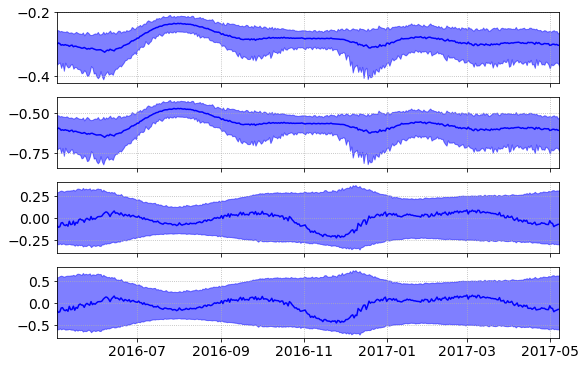

In [19]:
plt.figure(figsize=(9,6))
ax=plt.subplot(411)
plot_ensemble(dsout['time'], dsout['usurf'][:,0,0,:], axis=1)
ax.set_xticklabels([])
# plt.ylim(-0.04, 0.)

ax=plt.subplot(412)
plot_ensemble(dsout['time'], dsout['usurf'][:,0,1,:], axis=1)
ax.set_xticklabels([])
# plt.ylim(-0.04, 0.)

ax=plt.subplot(413)
plot_ensemble(dsout['time'], dsout['usurf'][:,1,0,:], axis=1)
ax.set_xticklabels([])
# plt.ylim(-0.1, 0.1)

ax=plt.subplot(414)
plot_ensemble(dsout['time'], dsout['usurf'][:,1,1,:], axis=1)
# plt.ylim(-0.1, 0.1)


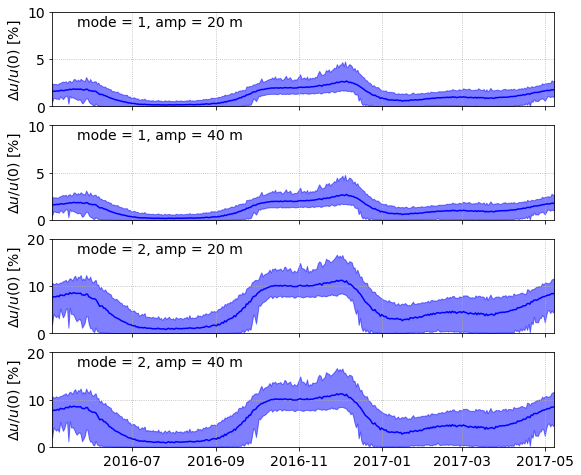

In [27]:
plt.figure(figsize=(9,8))
ax=plt.subplot(411)
plot_ensemble(dsout['time'], dsout['du'][:,0,0,:]/dsout['usurf'][:,0,0,:]*100,axis=1)
ax.set_xticklabels([])
# plt.ylim(-0.04, 0.)
plt.ylabel('$\Delta u/u(0)$ [%]')
plt.text(0.05, 0.85, 'mode = 1, amp = 20 m', transform=ax.transAxes)
plt.ylim(0,10)

ax=plt.subplot(412)
plot_ensemble(dsout['time'], dsout['du'][:,0,1,:]/dsout['usurf'][:,0,1,:]*100, axis=1)
ax.set_xticklabels([])
# plt.ylim(-0.04, 0.)
plt.ylabel('$\Delta u/u(0)$ [%]')
plt.text(0.05, 0.85, 'mode = 1, amp = 40 m', transform=ax.transAxes)
plt.ylim(0,10)

ax=plt.subplot(413)
plot_ensemble(dsout['time'], dsout['du'][:,1,0,:]/dsout['usurf'][:,1,0,:]*100, axis=1)
ax.set_xticklabels([])
plt.ylabel('$\Delta u/u(0)$ [%]')
plt.text(0.05, 0.85, 'mode = 2, amp = 20 m', transform=ax.transAxes)
plt.ylim(0,20)

ax=plt.subplot(414)
plot_ensemble(dsout['time'], dsout['du'][:,1,1,:]/dsout['usurf'][:,1,1,:]*100, axis=1)
plt.ylabel('$\Delta u/u(0)$ [%]')
plt.ylim(0,20)

plt.text(0.05, 0.85, 'mode = 2, amp = 40 m', transform=ax.transAxes)
plt.savefig('../FIGURES/Surface_VelocityRatio_Uncertainty_Linear.png', dpi=150)


In [33]:
def calc_nliw_rhophi(h5file, zmin, dz, tstep, \
            zsurf=-20, amps=[20.,40.], modes=[0,1], samples=None):
    
    # Lload the data
    #data,time, rho, depth, rho_std, z_std, rho_mu = load_density_h5(h5file)
    #data,time, rho_std, z_std, rho_mu = load_density_h5(h5file)
    z_std = 1.
    rho_std = 1.
    rho_mu = 0.
    data,time = load_beta_h5(h5file)
    nparams, nt, ntrace = data[:].shape
    
    zout = np.arange(0,zmin, -dz)
    
    zidx = np.argwhere(zout<=zsurf)[0,0]
    print(zsurf, zidx)

    # Calculate c and alpha
    if samples is None:
        samples = ntrace
    
    
    # Length of other dimensions
    nmodes = len(modes)
    namps = len(amps)
    nz = zout.shape[0]
    nt = 1
        
    rho_ens = np.zeros((nt, nz, samples))
    phiz_ens = np.zeros((nt, nz, nmodes, samples))


    rand_loc = np.random.randint(0, ntrace, samples)

    #for tstep in  tqdm(range(0,nt)):
        #if (tstep%20==0):
        #    print('%d of %d...'%(tstep,nt))
    for ii in range(samples):
        beta_ii = data[:,tstep, rand_loc[ii]]
        #beta_ens[tstep,ii,:] = beta_ii

        if nparams == 4:
            rhotmp = single_tanh(data[:,tstep, rand_loc[ii]], zout/z_std)
        elif nparams == 6:
            rhotmp = double_tanh(beta_ii, zout/z_std)
        elif nparams == 7:
            rhotmp = double_tanh_7(data[:,tstep, rand_loc[ii]], zout/z_std)

        # Need to scale rho
        rhotmp = rhotmp*rho_std + rho_mu

        rho_ens[0,:,ii] = rhotmp

        N2 = -9.81/1000*np.gradient(rhotmp,-dz)

        phi,cn = isw.iwave_modes(N2, dz)

        for mm, mode in enumerate(modes):

            phi_1 = phi[:,mode]
            phi_1 =phi_1 / np.abs(phi_1).max()
            phi_1 *= np.sign(phi_1.sum())

            #phi10 = isw.calc_phi10(phi_1, cn[mode], N2, dz)

            #alpha = isw.calc_alpha(phi_1, cn[mode],N2,dz)

            #alpha_ens[tstep, mm, ii] = alpha
            #c_ens[tstep, mm, ii] = cn[mode]
            phi_z = np.gradient(phi_1,-dz)
            phiz_ens[0,:,mm, ii] = phi_z
                #phi10_z = np.gradient(phi10,-dz)
           
            
    #     # Export to an xarray data set
    #     # Create an xray dataset with the output
    #     dimsc = ('time','mode','ensemble',)
    #     dimsu = ('time','mode','amp','ensemble',)

    #     #dims2a = ('time','depth',)
    #     dims3 = ('time','ensemble','params')

    #     #time = rho.time.values
    #     #time = range(nt)
    #     coords2 = {'time':time, 'ensemble':range(samples)}
    #     coordsc = {'time':time, 'mode':modes,'ensemble':range(samples)}
    #     coordsu = {'time':time, 'mode':modes,'amp':amps,'ensemble':range(samples)}

    #     #coords2a = {'time':time, 'depth':depth[:,0]}
    #     coords3 = {'time':time, 'ensemble':range(samples), 'params':range(nparams)}


    #     #rho = xr.DataArray(rho.T,
    #     #    coords=coords2a,
    #     #    dims=dims2a,
    #     #    attrs={'long_name':'', 'units':''},
    #     #    )

    #     cn_da = xr.DataArray(c_ens,
    #         coords=coordsc,
    #         dims=dimsc,
    #         attrs={'long_name':'', 'units':''},
    #         )

    #     alpha_da = xr.DataArray(alpha_ens,
    #         coords=coordsc,
    #         dims=dimsc,
    #         attrs={'long_name':'', 'units':''},
    #         )


    #     du_da = xr.DataArray(du_ens,
    #         coords=coordsu,
    #         dims=dimsu,
    #         attrs={'long_name':'', 'units':''},
    #         )

    #     usurf_da = xr.DataArray(usurf_ens,
    #         coords=coordsu,
    #         dims=dimsu,
    #         attrs={'long_name':'', 'units':''},
    #         )

    #     drho_da = xr.DataArray(drho_ens,
    #         coords=coords2,
    #         dims=dims2,
    #         attrs={'long_name':'', 'units':''},
    #         )
    #     beta_da = xr.DataArray(beta_ens,
    #         coords=coords3,
    #         dims=dims3,
    #         attrs={'long_name':'', 'units':''},
    #         )

    #     dsout = xr.Dataset({'cn':cn_da, 'alpha':alpha_da, 'beta':beta_da,
    #                        'du':du_da, 'usurf':usurf_da, 'drho':drho_da})

    return rho_ens, phiz_ens, zout, time[tstep]


In [38]:
rho_ens, phiz_ens, zout, t = calc_nliw_rhophi(h5file, zmin, dz, 343)
t, rho_ens.shape, phiz_ens.shape

-20 4


(numpy.datetime64('2017-04-12T18:40:00.000000000'),
 (1, 51, 500),
 (1, 51, 2, 500))

In [49]:
def plot_ens(z, x, ylim=None):
    nz, ns = x.shape
    for ii in range(ns):
        plt.plot(x[:,ii], z, 'navy', lw=0.2, alpha=0.1)
    
    if ylim is None:
        plt.ylim(z.min(), z.max())
    else:
        plt.ylim(ylim)

Text(0.5, 0, '$d \\phi_2/dz$ [m$^{-1}$]')

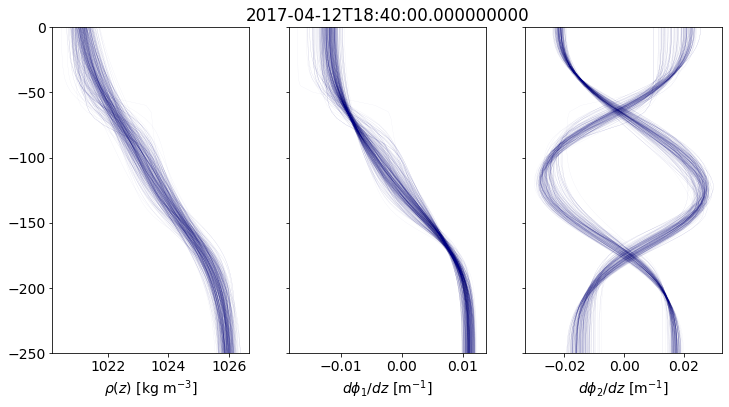

In [65]:
rho_ens.shape
# Plot (a) density ensembles, (b) phi_z (mode-1), (c) phi_z (mode-2)

plt.figure(figsize=(12,6))
ax=plt.subplot(131)
plot_ens(zout, rho_ens[0,:,:])
# ax.set_yticklabels([])
plt.xlabel(r'$\rho(z)$ [kg m$^{-3}$]')

ax=plt.subplot(132)
plot_ens(zout, phiz_ens[0,:,0, :])
ax.set_yticklabels([])
plt.xlabel('$d \phi_1/dz$ [m$^{-1}$]')
plt.title(t)

ax=plt.subplot(133)
plot_ens(zout, phiz_ens[0,:,1, :])
ax.set_yticklabels([])
plt.xlabel('$d \phi_2/dz$ [m$^{-1}$]')


# plt.subplot(234)
# plot_ens(zout, rho_ens[0,:,:], ylim=[-25,0])

Text(0.5, 0, '$d \\phi_2/dz$ [m$^{-1}$]')

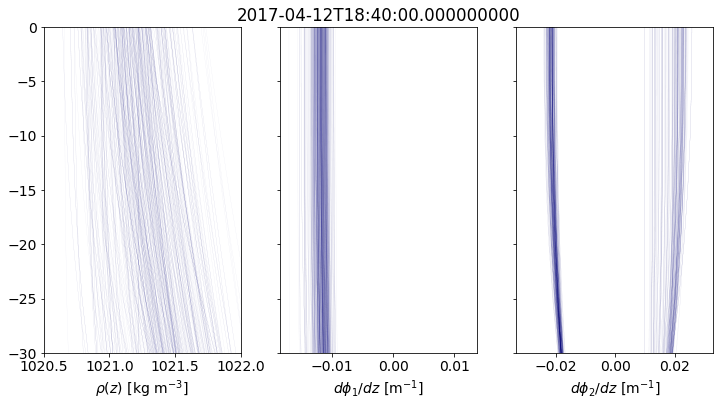

In [67]:

plt.figure(figsize=(12,6))
ax=plt.subplot(131)
plot_ens(zout, rho_ens[0,:,:], ylim=[-30,0])
# ax.set_yticklabels([])
plt.xlabel(r'$\rho(z)$ [kg m$^{-3}$]')
plt.xlim(1020.5,1022.0)

ax=plt.subplot(132)
plot_ens(zout, phiz_ens[0,:,0, :], ylim=[-30,0])
ax.set_yticklabels([])
plt.xlabel('$d \phi_1/dz$ [m$^{-1}$]')
plt.title(t)

ax=plt.subplot(133)
plot_ens(zout, phiz_ens[0,:,1, :], ylim=[-30,0])
ax.set_yticklabels([])
plt.xlabel('$d \phi_2/dz$ [m$^{-1}$]')